In [2]:
#!pip install graphviz

In [2]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [3]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [4]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [5]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    value = np.unique(label_array)[0] # Contains one of the binary classes
    p = len(label_array[label_array == value]) / len(label_array)
    
    if p == 0 or p == 1:
        return 0
    else: 
        return - p * np.log(p) - (1-p) * np.log(1-p)

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    
    value = np.unique(label_array)[0] # Contains one of the binary classes
    p = len(label_array[label_array == value]) / len(label_array)
    
    return 1 - p**2 - (1-p)**2

#### Other way

In [18]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False
        self.split_flag = False

    def fit(self, X, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recursive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        
        #If max depth is reached or the sample size is less than min sample, turn into leaf node
        if self.depth == self.max_depth or len(y) <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        best_loss = self.split_loss_function(y) # Save the initial loss for future comparison
        #print("Initial loss: ", best_loss)
        for col in range(X.shape[1]): # Loop over the columns X
            X, y = X[X[:, col].argsort()], y[X[:, col].argsort()] # Sort X by each column and sort y accordingly
            
            for split in range(1, X.shape[0]): # Loop over the rows of X
                # Let's split the data and evaluate the loss of each split
                X_top, y_top = X[:split,], y[:split]
                X_bottom, y_bottom = X[split:,], y[split:]
    
                top_loss = len(y_top) * self.split_loss_function(y_top) / len(y)
                bottom_loss = len(y_bottom) * self.split_loss_function(y_bottom) / len(y)
            
                total_loss = top_loss + bottom_loss
    
                if total_loss < best_loss:
                    best_split_value = X[split, col] # Save the value of the split
                    best_split_col = split # Save the index we split on
                    best_split_id = col # Save the column we split on
                    best_loss = total_loss # Save the current loss
                    best_X_top, best_y_top = X_top, y_top # Save the top split
                    best_X_bottom, best_y_bottom = X_bottom, y_bottom # Save the bottom split
                    self.split_flag = True
            print("Updated loss: ", best_loss)
            
        if self.split_flag == True:
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, self.min_sample, 
                                      self.max_depth)
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, self.min_sample, 
                                       self.max_depth)
        
            self.left.fit(best_X_top, best_y_top) # Recursive call using the top split
            self.right.fit(best_X_bottom, best_y_bottom) # Recursive call using the bottom split
            self.split_id = best_split_id
            self.split_value = best_split_value
            self.loss = best_loss
            
        else: 
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
    
        return self


    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

#### _

In [20]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False
        
        
    def find_best_split(self, X, y, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''

        best_loss = self.split_loss_function(y) # Baseline loss
        best_split_value = -1
        #print("Initial: ", best_loss)
        for split in range(1, X.shape[0]): # Loop over the rows of X
            # Let's split the data and evaluate the loss of each split
            X_top, y_top = X[:split,], y[:split]
            X_bottom, y_bottom = X[split:,], y[split:]

            top_loss = len(y_top) * self.split_loss_function(y_top) / len(y)
            bottom_loss = len(y_bottom) * self.split_loss_function(y_bottom) / len(y)

            if top_loss + bottom_loss < best_loss:
                best_split_value = split # Save the value of the split
                best_loss = top_loss + bottom_loss # Save the current loss
        return best_split_value, best_loss
    
    
    def find_best_feature_split(self, X, y):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''

        feature_split_losses, feature_split_values = [], []
        for feature in range(X.shape[1]): # Loop over the columns X
            X, y = X[X[:, feature].argsort()], y[X[:, feature].argsort()] # Sort X by each column and sort y accordingly
            split_value, best_loss = self.find_best_split(X, y, feature) # Calculates best split
            feature_split_losses.append(best_loss) # Save the best loss incurred by the selected feature
            feature_split_values.append(split_value) # Save the value associated to each loss 
        print("Updated", feature_split_losses[np.argmin(feature_split_losses)])
        self.split_id = np.argmin(feature_split_losses) # Returns the index of the lowest loss in the list
        self.split_value = feature_split_values[np.argmin(feature_split_losses)]

    def fit(self, X, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recursive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        
        #If max depth is reached or the sample size is less than min sample, turn into leaf node
        if self.depth == self.max_depth or len(y) <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self

        self.find_best_feature_split(X, y)
        print("Updated: ", best_loss)
            
        if self.split_value > 0: # I assign -1 if the split is not worth it
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, self.min_sample, 
                                      self.max_depth)
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, self.min_sample, 
                                       self.max_depth)
        
            X, y = X[X[:, self.split_id].argsort()], y[X[:, self.split_id].argsort()] # Sort X by each column and sort y accordingly
            X_top, y_top = X[:self.split_value,], y[:self.split_value]
            X_bottom, y_bottom = X[self.split_value:,], y[self.split_value:]
            #print("X_top: {}, X_bottom: {}".format(len(X_top), len(X_bottom)))
            self.left.fit(X_top, y_top) # Recursive call using the top split
            self.right.fit(X_bottom, y_bottom) # Recursive call using the bottom split
            
        else: 
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
    
        return self


    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [9]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [10]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

Updated:  0.47982791218562826
Updated:  0.4872243656652134
Updated:  0.47982791218562826
Updated:  0.4872243656652134
Updated:  0.07264219253019759
Updated:  0.04467878781590963
Updated:  0.4996235170087746
Updated:  0.543332194794529
Updated:  0.47982791218562826
Updated:  0.4872243656652134
Updated:  0.07264219253019759
Updated:  0.04467878781590963
Updated:  0.2772588722239781
Updated:  0.0
Updated:  0
Updated:  0
Updated:  0.4996235170087746
Updated:  0.543332194794529
Updated:  0.6737066538616454
Updated:  0.5144334502643718
Updated:  0.07958864977241167
Updated:  0.05751845219569846
Updated:  0.47982791218562826
Updated:  0.4872243656652134
Updated:  0.07264219253019759
Updated:  0.04467878781590963
Updated:  0.2772588722239781
Updated:  0.0
Updated:  0
Updated:  0
Updated:  0
Updated:  0
Updated:  0.4996235170087746
Updated:  0.543332194794529
Updated:  0.6737066538616454
Updated:  0.5144334502643718
Updated:  0.05134423559703299
Updated:  0.0926671154700348
Updated:  0.62014917

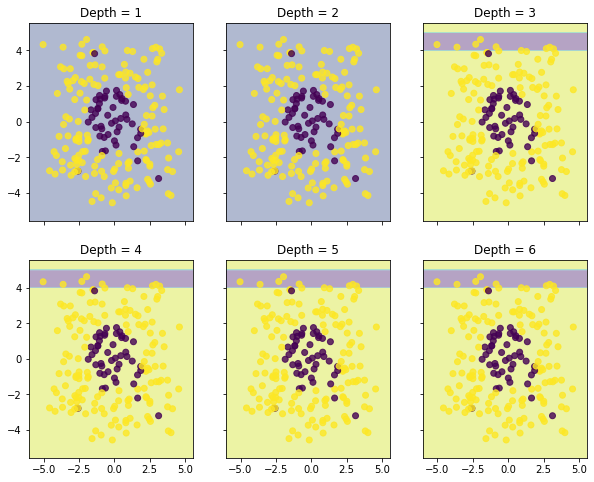

In [22]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

Updated loss:  0.47982791218562826
Updated loss:  0.47982791218562826
Updated loss:  0.47982791218562826
Updated loss:  0.47982791218562826
Updated loss:  0.07264219253019759
Updated loss:  0.04467878781590963
Updated loss:  0.4996235170087746
Updated loss:  0.4996235170087746
Updated loss:  0.47982791218562826
Updated loss:  0.47982791218562826
Updated loss:  0.07264219253019759
Updated loss:  0.04467878781590963
Updated loss:  0.2772588722239781
Updated loss:  0.0
Updated loss:  0
Updated loss:  0
Updated loss:  0.4996235170087746
Updated loss:  0.4996235170087746
Updated loss:  0.6737066538616454
Updated loss:  0.5144334502643718
Updated loss:  0.07958864977241167
Updated loss:  0.05751845219569846
Updated loss:  0.47982791218562826
Updated loss:  0.47982791218562826
Updated loss:  0.07264219253019759
Updated loss:  0.04467878781590963
Updated loss:  0.2772588722239781
Updated loss:  0.0
Updated loss:  0
Updated loss:  0
Updated loss:  0
Updated loss:  0
Updated loss:  0.49962351700

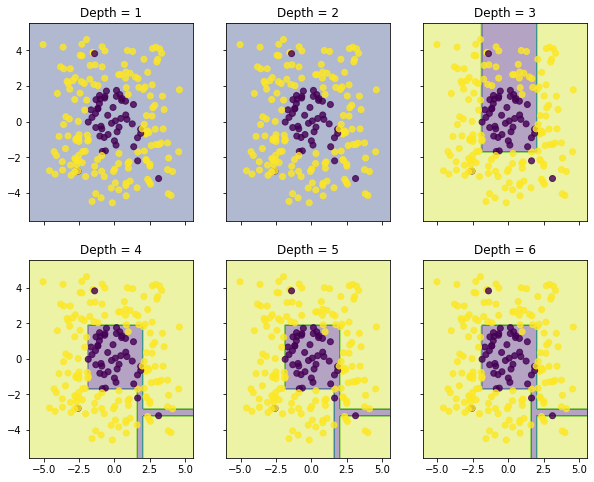

In [19]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [16]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

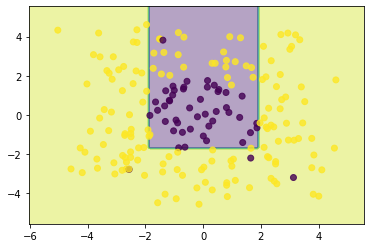

In [17]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

In [15]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

'dot' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [Errno 2] No such file or directory: 'tree_classifier.png'

# Decision Tree Regressor

In [317]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
   
    return mae

In [318]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

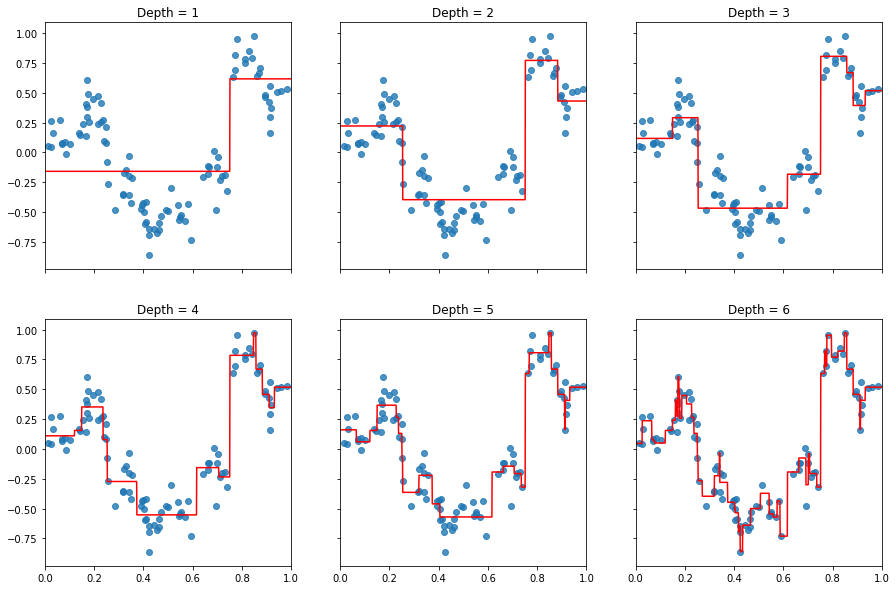

In [319]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Compare with scikit-learn for debugging

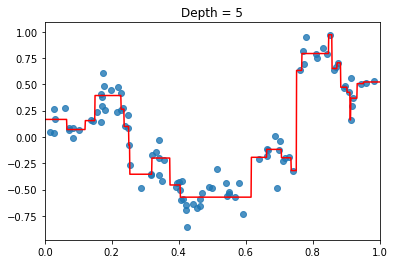

In [322]:
# DecisionTreeRegressor(criterion=, max_depth=, min_samples_split=)


# Gradient Boosting Method

In [325]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [341]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        # Your code goes here 
       
    
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        # Your code goes here
        
        return test_predict


# 1-D GBM visualization - KRR data

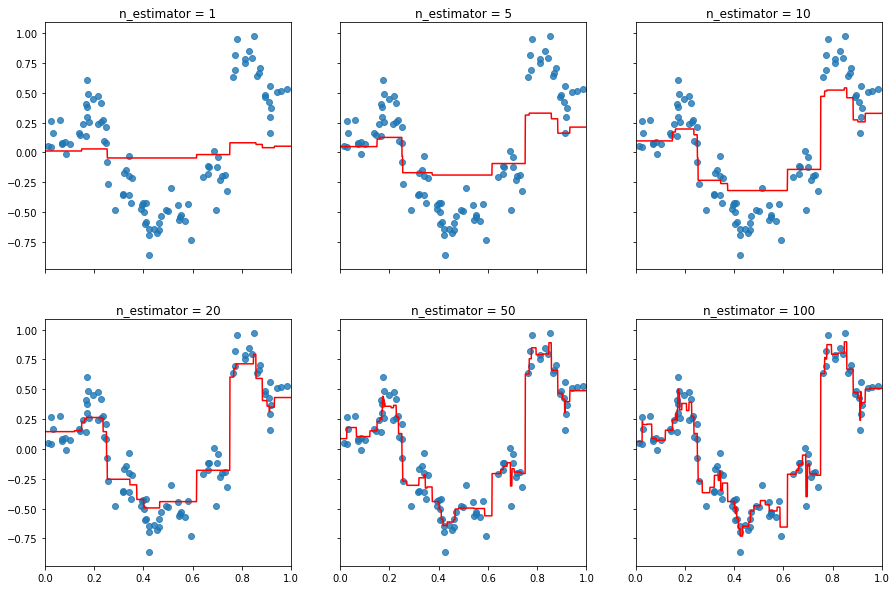

In [376]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Sklearn implementation for Classification of images

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state


In [444]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [445]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()